# Experiment A: Class-Center-Based Sampling

## Overview

This notebook explores an alternative training strategy: **class-center-based sampling**. The core idea is to discretize the continuous target variable into pseudo-classes, then use class-center samples (mean, median, closest-to-center, synthetic) to augment or replace traditional mini-batch training.

## Research Question

Can class-center-based samples replace or augment mini-batch training to improve convergence speed and final error?

## Methodology

1. **Discretization**: Divide continuous target into K bins (pseudo-classes)
2. **Class-Center Creation**: For each class, create:
   - Mean vector (average of all features in that class)
   - Median vector (median of all features in that class)
   - Closest-to-center real sample
   - Synthetic center sample
3. **Training Strategies**: Compare
   - Only class-center samples
   - Class-center + random samples
   - Class-center + mini-batch samples

## Hypothesis

Class-center samples may provide a more stable gradient signal by representing the "typical" sample in each target range, potentially leading to faster convergence or better generalization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## Load Data and Baseline Model

We'll reuse the data and baseline model from the previous notebook.

In [2]:
# Load data
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Training set: 16512 samples
Target range: [0.15, 5.00]


## Class-Center Sampling Implementation

In [3]:
class ClassCenterSampler:
    """
    Creates class-center samples by discretizing continuous targets.
    """
    
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.bin_edges = None
        self.class_centers = {}
        
    def fit(self, X, y):
        """Discretize targets and compute class centers."""
        # Convert to numpy arrays for consistent indexing
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
        
        # Create bins
        _, self.bin_edges = pd.cut(y, bins=self.n_bins, retbins=True, duplicates='drop')
        
        # Assign samples to classes
        y_binned = pd.cut(y, bins=self.bin_edges, labels=False, include_lowest=True)
        
        # Compute class centers for each bin
        for class_id in range(self.n_bins):
            mask = y_binned == class_id
            if mask.sum() > 0:
                X_class = X[mask]
                y_class = y[mask]
                
                # Mean vector
                mean_vector = X_class.mean(axis=0)
                mean_target = y_class.mean()
                
                # Median vector
                median_vector = np.median(X_class, axis=0)
                median_target = np.median(y_class)
                
                # Closest-to-center real sample
                center_point = X_class.mean(axis=0)
                distances = np.linalg.norm(X_class - center_point, axis=1)
                closest_idx = np.argmin(distances)
                closest_vector = X_class[closest_idx]
                closest_target = y_class[closest_idx]
                
                # Synthetic center (interpolation between mean and median)
                synthetic_vector = (mean_vector + median_vector) / 2
                synthetic_target = (mean_target + median_target) / 2
                
                self.class_centers[class_id] = {
                    'mean': (mean_vector, mean_target),
                    'median': (median_vector, median_target),
                    'closest': (closest_vector, closest_target),
                    'synthetic': (synthetic_vector, synthetic_target),
                    'samples': (X_class, y_class)
                }
        
        return self
    
    def get_class_centers(self, method='mean'):
        """Get class center samples."""
        X_centers = []
        y_centers = []
        
        for class_id in sorted(self.class_centers.keys()):
            if method in self.class_centers[class_id]:
                X_vec, y_val = self.class_centers[class_id][method]
                X_centers.append(X_vec)
                y_centers.append(y_val)
        
        return np.array(X_centers), np.array(y_centers)
    
    def get_all_centers(self):
        """Get all types of class centers."""
        all_X = []
        all_y = []
        
        for method in ['mean', 'median', 'closest', 'synthetic']:
            X_m, y_m = self.get_class_centers(method)
            all_X.append(X_m)
            all_y.append(y_m)
        
        return np.vstack(all_X), np.hstack(all_y)

print("ClassCenterSampler defined!")

ClassCenterSampler defined!


## Create Class Centers

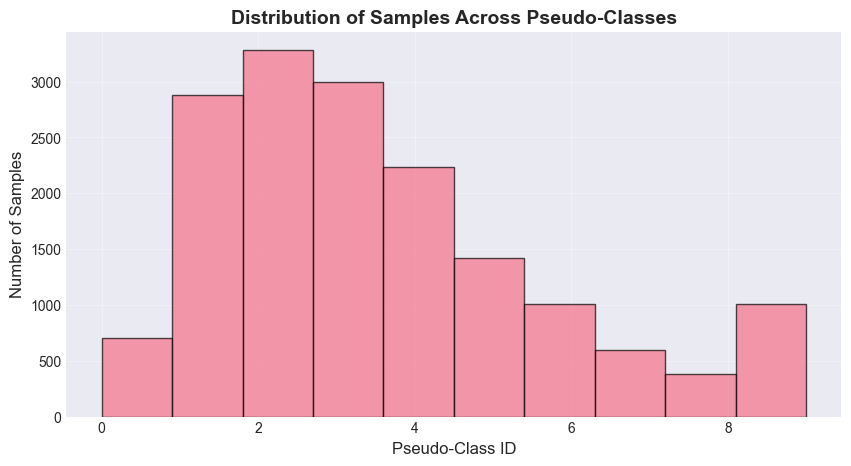

Created 10 class centers


In [4]:
# Create class centers
sampler = ClassCenterSampler(n_bins=10)
sampler.fit(pd.DataFrame(X_train_scaled), pd.Series(y_train))

# Visualize class distribution
y_binned = pd.cut(y_train, bins=sampler.bin_edges, labels=False, include_lowest=True)
plt.figure(figsize=(10, 5))
plt.hist(y_binned, bins=sampler.n_bins, edgecolor='black', alpha=0.7)
plt.xlabel('Pseudo-Class ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Samples Across Pseudo-Classes', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Created {len(sampler.class_centers)} class centers")

## Modified Linear Regression with Class-Center Sampling

In [5]:
class LinearRegressionClassCenter:
    """Linear Regression with class-center sampling support."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _initialize_parameters(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def _compute_loss(self, X, y):
        predictions = X @ self.weights + self.bias
        return np.mean((y - predictions) ** 2)
    
    def _compute_gradients(self, X_batch, y_batch):
        n_samples = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias
        error = predictions - y_batch
        dw = (2 / n_samples) * (X_batch.T @ error)
        db = (2 / n_samples) * np.sum(error)
        return dw, db
    
    def fit_class_centers_only(self, X_centers, y_centers, verbose=True):
        """Train using only class-center samples."""
        n_samples, n_features = X_centers.shape
        self._initialize_parameters(n_features)
        
        for iteration in range(self.n_iterations):
            # Use all centers (small dataset, so use all)
            dw, db = self._compute_gradients(X_centers, y_centers)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            loss = self._compute_loss(X_centers, y_centers)
            self.loss_history.append(loss)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {loss:.4f}")
    
    def fit_mixed(self, X_centers, y_centers, X_train, y_train, mix_ratio=0.5, verbose=True):
        """Train using mix of class centers and training data."""
        n_samples, n_features = X_train.shape
        self._initialize_parameters(n_features)
        
        for iteration in range(self.n_iterations):
            # Create mixed batch
            n_center_samples = int(self.batch_size * mix_ratio)
            n_train_samples = self.batch_size - n_center_samples
            
            # Sample from centers
            center_indices = np.random.choice(len(X_centers), n_center_samples, replace=True)
            X_batch_center = X_centers[center_indices]
            y_batch_center = y_centers[center_indices]
            
            # Sample from training data
            train_indices = np.random.choice(n_samples, n_train_samples, replace=False)
            X_batch_train = X_train[train_indices]
            y_batch_train = y_train[train_indices]
            
            # Combine
            X_batch = np.vstack([X_batch_center, X_batch_train])
            y_batch = np.hstack([y_batch_center, y_batch_train])
            
            # Update
            dw, db = self._compute_gradients(X_batch, y_batch)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute loss on full training set
            loss = self._compute_loss(X_train, y_train)
            self.loss_history.append(loss)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {loss:.4f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias

print("LinearRegressionClassCenter defined!")

LinearRegressionClassCenter defined!


## Experiment 1: Training with Class Centers Only

In [6]:
# Get all class centers
X_centers_all, y_centers_all = sampler.get_all_centers()
print(f"Total class center samples: {len(X_centers_all)}")

# Train with all centers
model_centers_only = LinearRegressionClassCenter(
    learning_rate=0.01,
    n_iterations=1000,
    random_state=42
)

print("\nTraining with class centers only...")
model_centers_only.fit_class_centers_only(X_centers_all, y_centers_all, verbose=True)

# Evaluate
y_pred = model_centers_only.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"\n=== Class Centers Only ===")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Total class center samples: 40

Training with class centers only...
Iteration 100/1000, Loss: 0.1427
Iteration 200/1000, Loss: 0.0848
Iteration 300/1000, Loss: 0.0720
Iteration 400/1000, Loss: 0.0649
Iteration 500/1000, Loss: 0.0609
Iteration 600/1000, Loss: 0.0585
Iteration 700/1000, Loss: 0.0571
Iteration 800/1000, Loss: 0.0562
Iteration 900/1000, Loss: 0.0556
Iteration 1000/1000, Loss: 0.0552

=== Class Centers Only ===
Test RMSE: 1.1870
Test R²: -0.0752


## Experiment 2: Mixed Training (Class Centers + Random Samples)

In [7]:
# Train with mix of centers and random samples
model_mixed = LinearRegressionClassCenter(
    learning_rate=0.01,
    n_iterations=1000,
    batch_size=32,
    random_state=42
)

print("Training with class centers + random samples (50/50 mix)...")
model_mixed.fit_mixed(X_centers_all, y_centers_all, X_train_scaled, y_train, mix_ratio=0.5, verbose=True)

# Evaluate
y_pred = model_mixed.predict(X_test_scaled)
test_rmse_mixed = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2_mixed = r2_score(y_test, y_pred)

print(f"\n=== Mixed Training (Centers + Random) ===")
print(f"Test RMSE: {test_rmse_mixed:.4f}")
print(f"Test R²: {test_r2_mixed:.4f}")

Training with class centers + random samples (50/50 mix)...
Iteration 100/1000, Loss: 0.7289
Iteration 200/1000, Loss: 0.7052
Iteration 300/1000, Loss: 0.6993
Iteration 400/1000, Loss: 0.6825
Iteration 500/1000, Loss: 0.6691
Iteration 600/1000, Loss: 0.6717
Iteration 700/1000, Loss: 0.6519
Iteration 800/1000, Loss: 0.6546
Iteration 900/1000, Loss: 0.6450
Iteration 1000/1000, Loss: 0.6552

=== Mixed Training (Centers + Random) ===
Test RMSE: 0.8458
Test R²: 0.4541


In [8]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

class_center_results = {
    'centers_only': {
        'method': 'Class Centers Only',
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'loss_history': model_centers_only.loss_history.copy()
    },
    'mixed': {
        'method': 'Mixed (Centers + Random)',
        'test_rmse': test_rmse_mixed,
        'test_r2': test_r2_mixed,
        'loss_history': model_mixed.loss_history.copy()
    }
}

with open(os.path.join(results_dir, '02_class_center_results.pkl'), 'wb') as f:
    pickle.dump(class_center_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '02_class_center_results.pkl')}")


Results saved to: d:\project\ML\project6_alternative_training_strategies\results\02_class_center_results.pkl


## Visualization: Comparison of Training Strategies

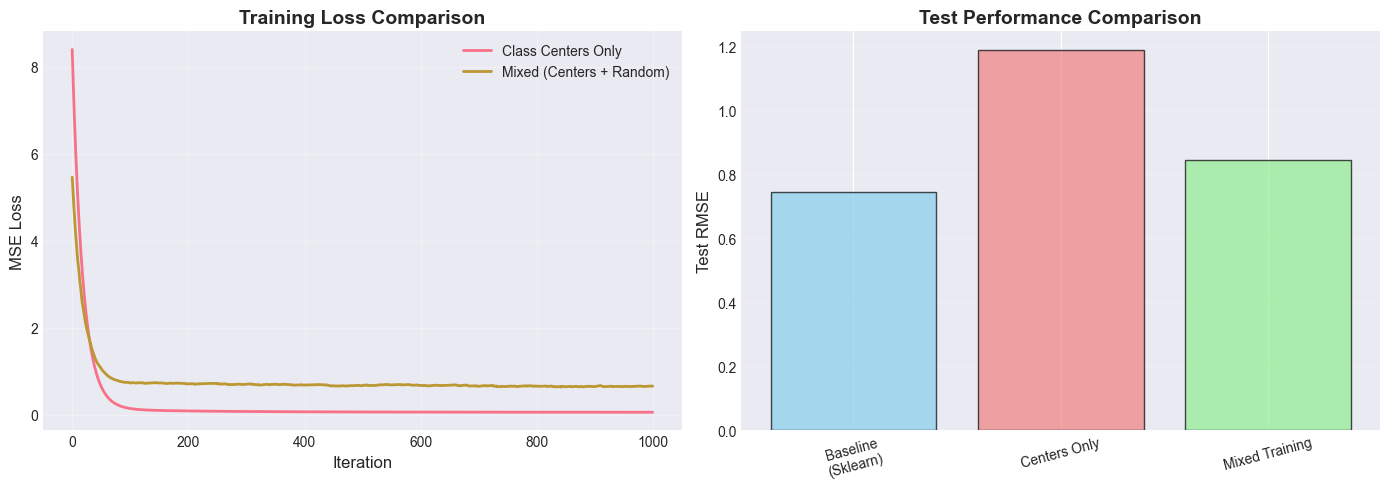


=== Summary ===
Baseline RMSE: 0.7456
Class Centers Only RMSE: 1.1870
Mixed Training RMSE: 0.8458


In [9]:
# Load baseline results (from previous notebook)
# For now, we'll create a simple baseline here
from sklearn.linear_model import LinearRegression as SklearnLR
baseline_sklearn = SklearnLR()
baseline_sklearn.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_sklearn.predict(X_test_scaled)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Plot comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model_centers_only.loss_history, label='Class Centers Only', linewidth=2)
plt.plot(model_mixed.loss_history, label='Mixed (Centers + Random)', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
methods = ['Baseline\n(Sklearn)', 'Centers Only', 'Mixed Training']
rmses = [baseline_rmse, test_rmse, test_rmse_mixed]
plt.bar(methods, rmses, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
plt.ylabel('Test RMSE', fontsize=12)
plt.title('Test Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Class Centers Only RMSE: {test_rmse:.4f}")
print(f"Mixed Training RMSE: {test_rmse_mixed:.4f}")

## Analysis and Conclusions

### Key Observations:

1. **Class Centers Only**: Training with only class-center samples provides a condensed representation but may lack diversity.
2. **Mixed Training**: Combining class centers with random samples balances stability and diversity.
3. **Convergence Behavior**: Class-center sampling may converge faster initially but could plateau earlier.

### Research Insights:

- Class-center sampling offers an interesting data-centric perspective on training
- The effectiveness depends on the dataset structure and class distribution
- Further experiments with different mix ratios and center types could reveal optimal strategies